In [1]:
import shap
import numpy as np
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.model_selection import (StratifiedKFold, GridSearchCV, RandomizedSearchCV,
                                     train_test_split, KFold)
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, precision_recall_curve, average_precision_score,
                             make_scorer)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import set_config
from sklearn.pipeline import make_pipeline

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import geometric_mean_score
from imblearn.pipeline import make_pipeline, Pipeline

from xgboost import XGBClassifier
from scipy.stats import randint, uniform

from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored, brier_score
from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator
from sklearn.inspection import permutation_importance

%matplotlib inline
set_config(display="text")  # displays text representation of estimators

from datetime import timedelta
import pickle

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/anaconda3/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


#import sklearn
#print(sklearn.__version__)
#1.0.2

#Name: scikit-learn
Version: 1.0.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /opt/anaconda3/lib/python3.9/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: aif360, category-encoders, fairlearn, fancyimpute, FLAML, imbalanced-ensemble, imbalanced-learn, impyute, lightgbm, mlxtend, nannyml, nilearn, scikit-learn-intelex, scikit-survival, shap, tempeh, yellowbrick
Note: you may need to restart the kernel to use updated packages.

In [2]:
PAT = '/Users/marinacamacho/Desktop/Master_I/Data_Final'
DIS = 'Depression_3'
MOD = 'SA_3'
rstate = 27

In [3]:
# Read trainCohort_{DIS} file
with open(f"{PAT}/trainCohort_{DIS}", "rb") as fp:
    trainData = pickle.load(fp)
# Read trainLabels_{DIS} file
with open(f"{PAT}/trainLabels_{DIS}", "rb") as fp:
    y_train = pickle.load(fp)

# Read externalCohort_{DIS} file
with open(f"{PAT}/externalCohort_{DIS}", "rb") as fp:
    extCohort = pickle.load(fp)
# Read externalLabels_{DIS} file
with open(f"{PAT}/externalLabels_{DIS}", "rb") as fp:
    y_ext = pickle.load(fp)

# Read traceCohort_{DIS} file
with open(f"{PAT}/traceCohort_{DIS}", "rb") as fp:
    traceCohort = pickle.load(fp)
# Read traceLabels_{DIS} file
with open(f"{PAT}/traceLabels_{DIS}", "rb") as fp:
    y_trace = pickle.load(fp)

In [4]:
outputs = [y_train, y_ext, y_trace]
cols = ['visit0', 'visit0', 'visit1']

for element in range(0,len(outputs)):

    # Convert strings to datetime format
    outputs[element]['Depression'] = pd.to_datetime(outputs[element]['Depression'])
    outputs[element]['visit0'] = pd.to_datetime(outputs[element][cols[element]])

    # Calculate difference in days
    outputs[element]['time'] = ((outputs[element]['Depression'] - outputs[element]['visit0']).dt.days).fillna(-1).astype(int)
    outputs[element]['time'] = outputs[element]['time'].replace(-1, max(y_train['time'])+1)

    outputs[element].rename(columns={'target': 'event'}, inplace=True)
    outputs[element]['event'] = outputs[element]['event'].astype(bool)
    del outputs[element]['Depression']
    del outputs[element][cols[element]]
    
    outputs[element] = np.array(list(zip(outputs[element]['event'], outputs[element]['time'])), 
                                dtype=[('event', np.bool_), ('time', np.float32)])

In [5]:
imputer = SimpleImputer(strategy='mean')
trainData = imputer.fit_transform(trainData)
extCohort = imputer.transform(extCohort)
traceCohort = imputer.transform(traceCohort)

In [6]:
trainData.shape, extCohort.shape, traceCohort.shape

((73344, 175), (31444, 175), (3967, 175))

In [6]:
model1 = RandomSurvivalForest(
    n_estimators=50,
    min_samples_split=7,
    min_samples_leaf=10,
    max_features=45,  
    random_state=rstate)

In [7]:
# Convert y_rf_train_1 to structured array
y_train = np.array(list(zip(y_train['event'].values, y_train['time'].values)), 
                                  dtype=[('event', np.bool_), ('time', np.float32)])

y_ext = np.array(list(zip(y_ext['event'].values, y_ext['time'].values)), 
                                  dtype=[('event', np.bool_), ('time', np.float32)])

y_trace = np.array(list(zip(y_trace['event'].values, y_trace['time'].values)), 
                                  dtype=[('event', np.bool_), ('time', np.float32)])

In [9]:
model1.fit(trainData, np.array(y_train))

RandomSurvivalForest(max_features=45, min_samples_leaf=10, min_samples_split=7,
                     n_estimators=50, random_state=27)

In [10]:
with open(f"{PAT}/{MOD}/fitted_models_RSF{DIS}", "wb") as fp:
                    pickle.dump(model1, fp)

In [11]:
model1.score(extCohort, y_ext)

0.8149575233021344

In [12]:
model1.score(traceCohort, y_trace)

0.8394834011725891

In [13]:
predictions_1 = model1.predict_survival_function(extCohort, return_array=True)
with open(f"{PAT}/{MOD}/predictions_ext_RSF{DIS}", "wb") as fp:
                    pickle.dump(predictions_1, fp)
        
predictions_2 = model1.predict_survival_function(traceCohort, return_array=True)    
with open(f"{PAT}/{MOD}/predictions_trace_RSF{DIS}", "wb") as fp:
                    pickle.dump(predictions_2, fp)

In [8]:
with open(f"{PAT}/{MOD}/fitted_models_RSF{DIS}", "rb") as fp:
    model1 = pickle.load(fp)

In [8]:
model1

RandomSurvivalForest(max_features=45, min_samples_leaf=10, min_samples_split=7,
                     n_estimators=50, random_state=27)

In [9]:
from sklearn.inspection import permutation_importance

In [10]:
# Convert the DataFrame to a structured numpy array
y_train_structured = np.array(list(zip(y_train['event'], y_train['time'])), 
                              dtype=[('event', np.bool_), ('time', np.float64)])

In [ ]:
result = permutation_importance(model1, trainData, y_train_structured, n_repeats=3, random_state=27)

In [ ]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=trainData.columns,
).sort_values(by="importances_mean", ascending=False)

In [13]:
surv = model1.predict_survival_function(extCohort, return_array=True)

In [18]:
surv2 = model1.predict_cumulative_hazard_function(extCohort, return_array=True)

In [19]:
surv3 = model1.predict_survival_function(traceCohort, return_array=True)

In [65]:
surv4 = model1.predict_cumulative_hazard_function(traceCohort, return_array=True)

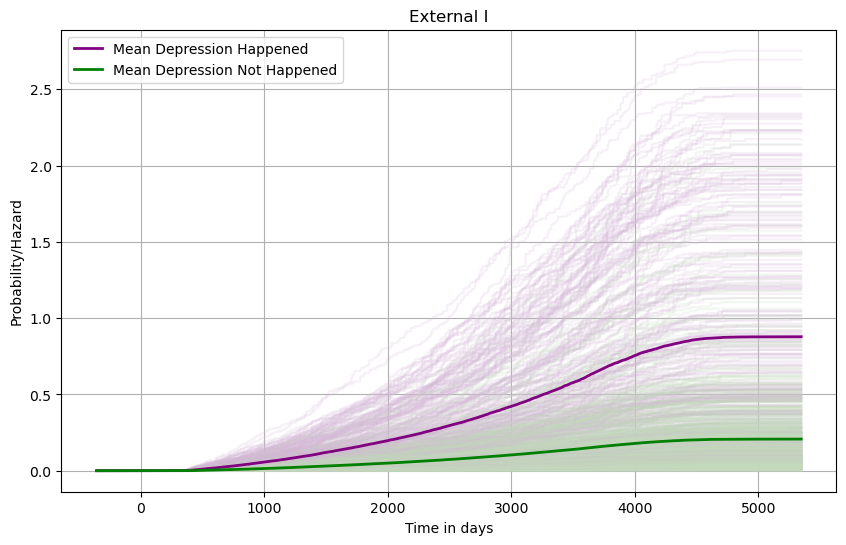

In [100]:
# Set up the data
condition = list(pd.DataFrame(y_ext)['event'].tail(1000))
condition_colors = ['#D5B8D8' if cond else '#C3D8BD' for cond in condition]
event_test = list(pd.DataFrame(y_ext)['event'])
event_happened = [chf for chf, event in zip(surv2, event_test) if event]
event_not_happened = [chf for chf, event in zip(surv2, event_test) if not event]

mean_chf_event_happened = np.mean(event_happened, axis=0)
mean_chf_event_not_happened = np.mean(event_not_happened, axis=0)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot individual survival curves
for i, (s, c) in enumerate(zip(surv2[-1000:], condition_colors)):
    plt.step(model1.unique_times_, s, where="post", color=c, alpha=0.2)  # Reduced opacity for clarity

# Plot mean cumulative hazard functions
plt.plot(model1.unique_times_, mean_chf_event_happened, label="Mean Depression Happened", color='purple', linewidth=2)
plt.plot(model1.unique_times_, mean_chf_event_not_happened, label="Mean Depression Not Happened", color='green', linewidth=2)

# Setting labels, legends, and grid
plt.title("External I")
plt.xlabel("Time in days")
plt.ylabel("Probability/Hazard")
plt.legend(loc='upper left')
plt.grid(True)

# Save the plot with high resolution
plt.savefig("hazard_plot_ext.png", dpi=300, bbox_inches='tight')

plt.show()

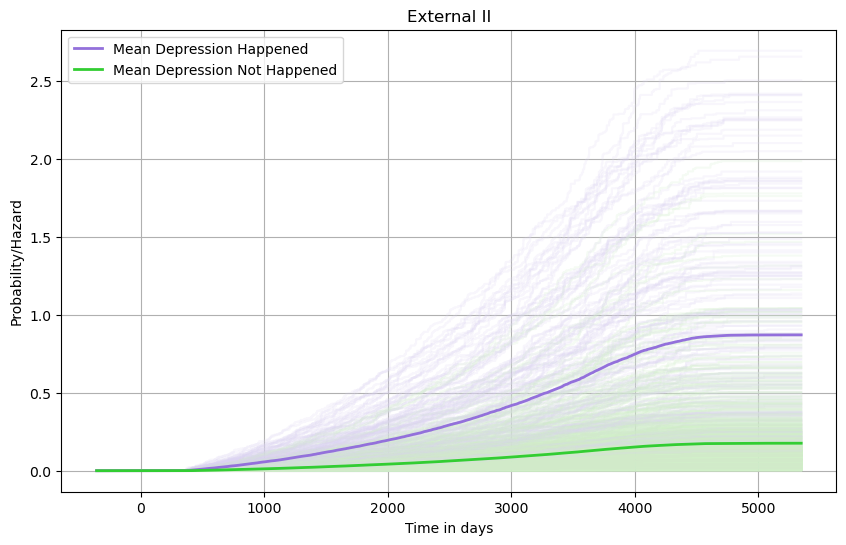

In [102]:
# Set up the data
condition = list(pd.DataFrame(y_trace)['event'].tail(1000))
condition_colors = ['#DCD4F2' if cond else '#D1EFC9' for cond in condition]
event_test = list(pd.DataFrame(y_trace)['event'])
event_happened = [chf for chf, event in zip(surv4, event_test) if event]
event_not_happened = [chf for chf, event in zip(surv4, event_test) if not event]

mean_chf_event_happened = np.mean(event_happened, axis=0)
mean_chf_event_not_happened = np.mean(event_not_happened, axis=0)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot individual survival curves
for i, (s, c) in enumerate(zip(surv4[-1000:], condition_colors)):
    plt.step(model1.unique_times_, s, where="post", color=c, alpha=0.2)  # Reduced opacity for clarity

# Plot mean cumulative hazard functions
plt.plot(model1.unique_times_, mean_chf_event_happened, label="Mean Depression Happened", color='#9370DB', linewidth=2)
plt.plot(model1.unique_times_, mean_chf_event_not_happened, label="Mean Depression Not Happened", color='#32CD32', linewidth=2)

# Setting labels, legends, and grid
plt.title("External II")
plt.xlabel("Time in days")
plt.ylabel("Probability/Hazard")
plt.legend(loc='upper left')
plt.grid(True)

# Save the plot with high resolution
plt.savefig("hazard_plot_trace.png", dpi=300, bbox_inches='tight')

plt.show()

In [122]:
# Split the external cohort based on events
event_occurred = y_ext['event'] == True

X_ext_event_occurred = extCohort[event_occurred]
y_ext_event_occurred = y_ext[event_occurred]

In [123]:
# Compute the C-index for each subset
c_index_event_occurred = model1.score(X_ext_event_occurred, y_ext_event_occurred)
print(f"C-index for samples where the event occurred: {c_index_event_occurred:.2f}")

C-index for samples where the event occurred: 0.53


In [124]:
# Split the external cohort based on events
event_occurred = y_trace['event'] == True

X_trace_event_occurred2 = traceCohort[event_occurred]
y_trace_event_occurred2 = y_trace[event_occurred]

In [125]:
# Compute the C-index for each subset
c_index_event_occurred_2 = model1.score(X_trace_event_occurred2, y_trace_event_occurred2)
print(f"C-index for samples where the event occurred: {c_index_event_occurred_2:.2f}")

C-index for samples where the event occurred: 0.53


In [104]:
import numpy as np
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index

In [107]:
# Assume data is in df with time column "T" and event column "E"
# Fitting a Cox Proportional Hazards model
df = pd.DataFrame(y_ext)
cph = CoxPHFitter()
cph.fit(df, duration_col='time', event_col='event')

# 1. Concordance Index
ci = concordance_index(df['time'], -cph.predict_partial_hazard(df), df['event'])
print(f"Concordance Index: {ci}")

Concordance Index: 0.5


In [113]:
# Assume data is in df with time column "T" and event column "E"
# Fitting a Cox Proportional Hazards model
df2 = pd.DataFrame(y_trace)
cph2 = CoxPHFitter()
cph2.fit(df2, duration_col='time', event_col='event')

# 1. Concordance Index
ci2 = concordance_index(df2['time'], -cph2.predict_partial_hazard(df2), df2['event'])
print(f"Concordance Index: {ci2}")

Concordance Index: 0.5


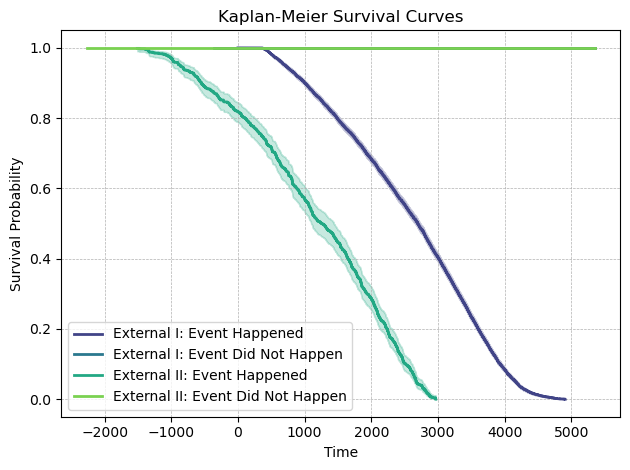

In [115]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Initialize Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Use viridis color palette
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 4))

# For df where event happened
mask_event_df = df['event'] == 1
kmf.fit(df[mask_event_df]['time'], event_observed=df[mask_event_df]['event'], label="External I: Event Happened")
ax = kmf.plot(color=colors[0], linewidth=2)

# For df where event did not happen
mask_no_event_df = df['event'] == 0
kmf.fit(df[mask_no_event_df]['time'], event_observed=df[mask_no_event_df]['event'], label="External I: Event Did Not Happen")
kmf.plot(ax=ax, color=colors[1], linewidth=2)

# For df2 where event happened
mask_event_df2 = df2['event'] == 1
kmf.fit(df2[mask_event_df2]['time'], event_observed=df2[mask_event_df2]['event'], label="External II: Event Happened")
kmf.plot(ax=ax, color=colors[2], linewidth=2)

# For df2 where event did not happen
mask_no_event_df2 = df2['event'] == 0
kmf.fit(df2[mask_no_event_df2]['time'], event_observed=df2[mask_no_event_df2]['event'], label="External II: Event Did Not Happen")
kmf.plot(ax=ax, color=colors[3], linewidth=2)

# Customize the plot
plt.title('Kaplan-Meier Survival Curves')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save the plot with high resolution
plt.savefig("kaplan_plot_comparison.png", dpi=300, bbox_inches='tight')

plt.show()

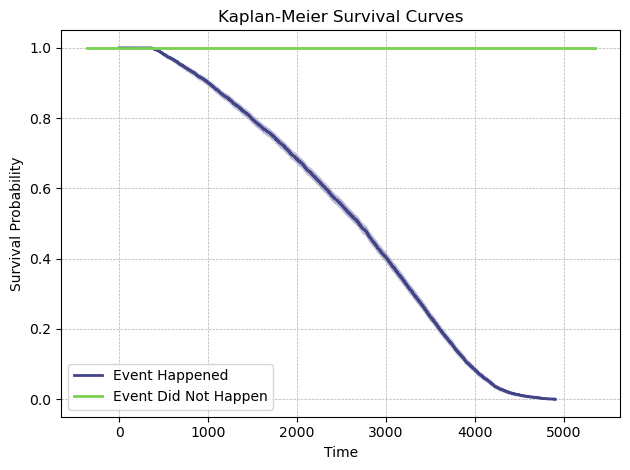

In [126]:
# Initialize Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Use viridis color palette
colors = plt.cm.viridis([0.2, 0.8])

# For those where event happened
mask_event = df['event'] == 1
kmf.fit(df[mask_event]['time'], event_observed=df[mask_event]['event'], label="Event Happened")
ax = kmf.plot(color=colors[0], linewidth=2)

# For those where event did not happen
mask_no_event = df['event'] == 0
kmf.fit(df[mask_no_event]['time'], event_observed=df[mask_no_event]['event'], label="Event Did Not Happen")
kmf.plot(ax=ax, color=colors[1], linewidth=2)

# Customize the plot
plt.title('Kaplan-Meier Survival Curves')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save the plot with high resolution
plt.savefig("kaplan_plot.png", dpi=300, bbox_inches='tight')

plt.show()

In [116]:
# 3. Log-rank Test (if you have two groups)
results = logrank_test(df[mask_event]['time'], df[mask_no_event]['time'],
                       event_observed_A=df[mask_event]['event'], event_observed_B=df[mask_no_event]['event'])

print(results.print_summary())

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
       53202.35 <0.005       inf

None


The large test statistic and the very small p-value (<0.005) suggest that there's a statistically significant difference between the survival curves of the two groups. In other words, the time-to-event distribution (or survival probabilities over time) is different for individuals where the event happened compared to those where it did not happen.

In [118]:
# 3. Log-rank Test (if you have two groups)
results = logrank_test(df2[mask_event]['time'], df2[mask_no_event]['time'],
                       event_observed_A=df2[mask_event]['event'], event_observed_B=df2[mask_no_event]['event'])

print(results.print_summary())

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.86 0.35      1.50

None


In summary, based on the log-rank test results provided, there is no statistically significant difference between the survival curves of the two groups being compared.